In [1]:
# !pip install -e markov_epidemic

import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.optimize import curve_fit

from markov_epidemic import *

## SIR Epidemic

Consider a network $\mathcal{G}$ of $N$ individuals subject to an epidemic disease.
Let $A$ be the adjacency matrix of the underlying graph and $X_i(t)$ the health state of individual $i$ at time $t$.

We assume the following random Markov dynamic:

$$
\begin{cases} 
      \text{healthy} \rightarrow \text{infected} & \text{at rate $\beta\sum_j A_{ij} \mathbb{1}_{X_j(t) = \text{infected}}$,}  \\
      \text{infected} \rightarrow \text{recovered} & \text{at rate $\delta$.} \\
   \end{cases}
$$

In other words, the infection rate of an individual is proportional to the number of infected neighbors in the network, and the recovery rate is constant, but once an individual has recovered it can never be infected again. Also we assume only one individual can change state at a given time $t$ (the events of multiple simultaneous transitions have probability zero anyway).

This is a **Susceptible-Infected-Recovered (SIR)** model. 

## Sparse vs dense networks

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


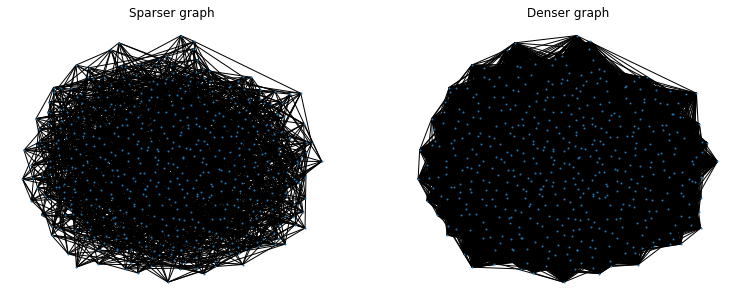

In [2]:
N = 500
G1 = nx.random_regular_graph(10, N)
G2 = nx.random_regular_graph(100, N)

# save layout
pos = nx.spring_layout(G1)

fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

ax = axes[0]
nx.draw_networkx(G1, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Sparser graph')
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G2, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Denser graph')
ax.axis('off')

plt.show()

### Epidemic parameters

In [3]:
infection_rate = 1.0
recovery_rate = 2.5
epidemic1 = MarkovSIR(infection_rate, recovery_rate, G1)
epidemic2 = MarkovSIR(infection_rate, recovery_rate, G2)

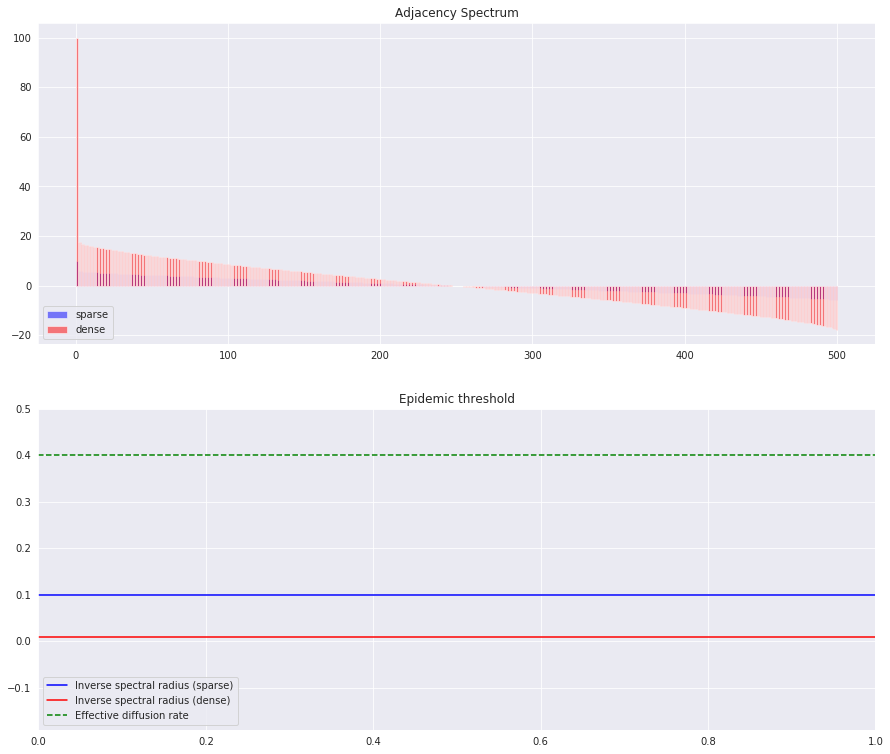

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(15, 13), nrows=2, ncols=1)

    ax = axes[0]
    ax.bar(range(1, N+1), epidemic1.spectrum, label='sparse', color='b', alpha=0.5)
    ax.bar(range(1, N+1), epidemic2.spectrum, label='dense', color='r', alpha=0.5)
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')
    
    ax = axes[1]
    isr1 = 1/epidemic1.spectral_radius
    edr = epidemic1.effective_diffusion_rate
    isr2 = 1/epidemic2.spectral_radius
    
    ax.axhline(y=isr1, color='b', label='Inverse spectral radius (sparse)')
    ax.axhline(y=isr2, color='r', label='Inverse spectral radius (dense)')
    ax.axhline(y=edr, color='g', label='Effective diffusion rate', linestyle='dashed')

    ax.set_xlim(0, 1)
    ax.set_ylim(np.min((edr, isr1, isr2))-0.2, np.max((edr, isr1, isr2))+0.1)
    ax.set_title('Epidemic threshold')
    ax.legend(loc='lower left')

    plt.show()

### Epidemic simulation

In [5]:
T = 10.0
initial_infected = 5

epidemic1.simulate(T, epidemic1.random_seed_nodes(initial_infected))
epidemic2.simulate(T, epidemic2.random_seed_nodes(initial_infected))

/home/sauxpa/github/markov_epidemic/markov_epidemic/markov_epidemic/markov_epidemic.py:233: RuntimeWarning: divide by zero encountered in true_divide
  holding_times = np.random.exponential(scale=1/rates)


### Smooth curve fitting

In [6]:
def normal(x, mu, sigma, scale):
    return scale * np.exp(-(x-mu)**2/(2*sigma**2))

def lognormal(x, mu, sigma, scale):
     return scale * np.exp(-sigma * np.log((x + 1e-10) / mu)**2)

In [7]:
popt1_normal, _ = curve_fit(normal, epidemic1.transition_times, epidemic1.number_of_infected/epidemic1.N, p0=(1.0, 1.0, 1.0))
popt2_lognormal, _ = curve_fit(lognormal, epidemic2.transition_times, epidemic2.number_of_infected/epidemic2.N, p0=(0.1, 1.0, 1.0))

normal1 = lambda x: normal(x, popt1_normal[0], popt1_normal[1], popt1_normal[2])
lognormal2 = lambda x: lognormal(x, popt2_lognormal[0], popt2_lognormal[1], popt2_lognormal[2])

### Plot comparison

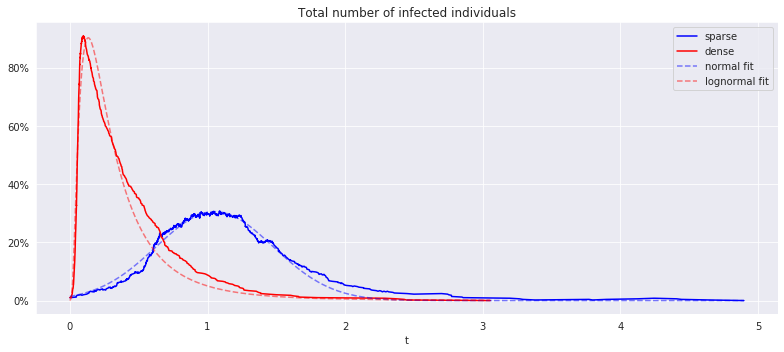

In [8]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(11, 5), nrows=1, ncols=1)

    ax.plot(epidemic1.transition_times, epidemic1.number_of_infected/epidemic1.N, color='b', label='sparse')
    ax.plot(epidemic2.transition_times, epidemic2.number_of_infected/epidemic2.N, color='r', label='dense')
    
    ax.plot(epidemic1.transition_times, 
            normal1(epidemic1.transition_times), 
            color='b', 
            linestyle='dashed', 
            label='normal fit',
            alpha=0.5,
           )
    ax.plot(epidemic2.transition_times, 
            lognormal2(epidemic2.transition_times), 
            color='r', 
            linestyle='dashed',
            label='lognormal fit',
            alpha=0.5,
           )
    
    ax.set_title('Total number of infected individuals')
    ax.set_xlabel('t')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

## Comparison with deterministic baseline

The corresponding deterministic system is :

* $\frac{dS}{dt} = -\bar{d}\beta\frac{IS}{N}$,
* $\frac{dI}{dt} = \bar{d}\beta\frac{IS}{N}-\delta I$,
* $\frac{dR}{dt} = \delta I$,

where $\bar{d}$ is the average degree of the network.

This can be seen as the expected evolution of the Markovian dynamic. However it lacks its flexibility in terms of network modelling : as it relies on an average degree assumption, it is only really accurate for regular graphs.

In [9]:
infection_rate = 1.0
recovery_rate = 1.0
k = 5
T = 10.0
initial_infected = 50

G = nx.random_regular_graph(k, N)
epidemic = MarkovSIR(infection_rate, recovery_rate, G)

# Stochastic evolution
epidemic.simulate(T, epidemic.random_seed_nodes(initial_infected))

# Deterministic evolution
t, y = epidemic.deterministic_baseline(T, initial_infected, k)

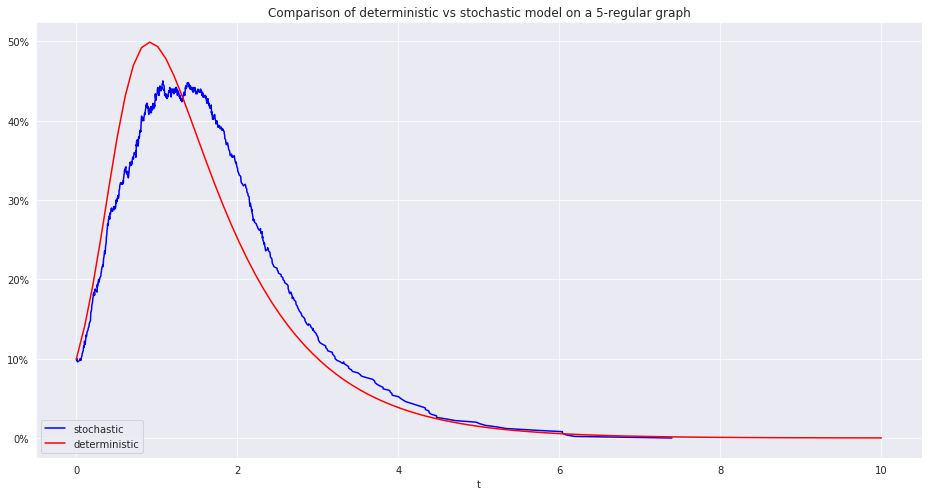

In [10]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(13, 7), nrows=1, ncols=1)

    ax.plot(epidemic.transition_times, epidemic.number_of_infected/epidemic.N, color='b', label='stochastic')
    ax.plot(t, y[1]/epidemic.N, label='deterministic', color='r')
    ax.set_xlabel('t')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_title('Comparison of deterministic vs stochastic model on a {}-regular graph'.format(k))
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()